<a href="https://colab.research.google.com/github/tweyde/City-Data-Science/blob/master/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module INM378/IN3031: Digital Signal Processing and Audio Programming
## Lab 7 - Real-Time DSP in Python

## Solutions

### 0. Setup dependencies

In [1]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/jpauwels/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

/content/city_dsp_ap


In [2]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio, display
import matplotlib.pyplot as plt

### 1. Filter coefficient interpolation

One easy way to create a dynamically controllable filter is to take two stationary filters and interpolate between them, where the control signal determines how much each of the two filters contributes to the final filter. We can directly interpolate the **filter coefficients B (and optionally A for IIR filters)** , where the result will be a new B (and A) representing the new filter.

If you need a refresher about the technique of linear interpolation, you can consult [Wikipedia](https://en.wikipedia.org/wiki/Linear_interpolation). As a simple example, suppose we have a control signal ranging between $0$ and $1$. Assume that we want a control value of $0$ to correspond to a FIR filter 1 with coefficients $B_1$ and a control value of $1$ to correspond to a FIR filter 2 with coefficients $B_2$. Then we can create a filter for control values between 0 and 1 by taking a fraction of filter 1's coefficients and the complementary fraction of filter 2's coefficients such that both fractions sum to 1:
$B(x) = (1-x) B_1 + x B_2$. Note that $B(0) = B_1$ and $B(1) = B_2$. A filter for a control value of $0.4$ would be $B(0.4)=0.6 B_1 + 0.4 B_2$, for instance. The full formula for arbitrary ranges of control values can be found on Wikipedia.

In [3]:
samplerate, samples = wavfile.read('audio/rockB.wav')
mono_samples = np.mean(samples, axis=-1)

Now create two different FIR filters of the same length (say $21$, so of order $20$) using [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) from the `scipy.signal` library (check lab 5 for an example, if you need). These filters can be different in cut-off frequencies or different types. Then create multiple new filters from these two filters by linearly interpolating the filter coefficients for multiple interpolation values. Smoothly varying the interpolation values will give you a smooth transition between two filters, which will come in handy for the PG coursework.

Test your implementation by applying the filters to `mono_samples`, loaded from the audio file above. You can also use the `plot_filter` function of lab 5 (replicated below) to visualise the evolution of the filter responses.

In [4]:
def plot_filter(b, a, samplerate=None):
    w, h = signal.freqz(b, a)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    freqs = w / (2*np.pi)
    if samplerate:
        freqs *= samplerate
        ax1.set_xlabel('frequency [Hz]')
    else:
        ax1.set_xlabel('normalised frequency [cycles/sample]')

    ax1.plot(freqs, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('amplitude [dB]', color='b')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(freqs, angles, 'g')
    ax2.set_ylabel('angle [radians]', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

100% of filter 1 mixed with 0% of filter 2


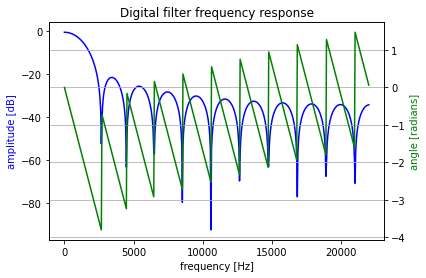

75% of filter 1 mixed with 25% of filter 2


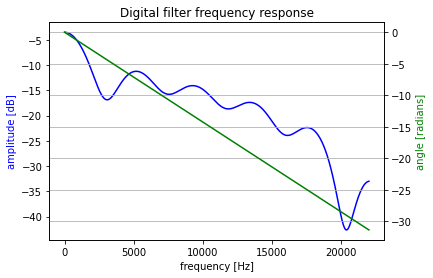

50% of filter 1 mixed with 50% of filter 2


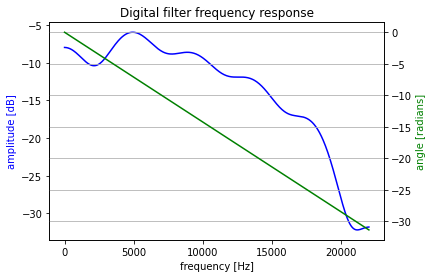

25% of filter 1 mixed with 75% of filter 2


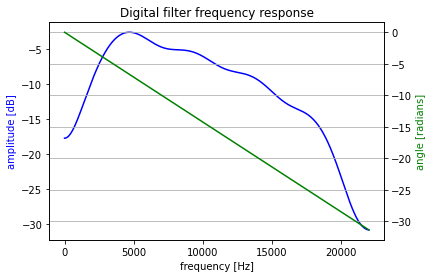

0% of filter 1 mixed with 100% of filter 2


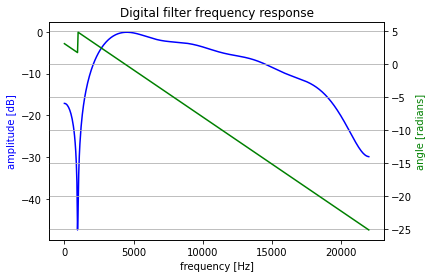

In [7]:
filt_len = 21

b_filt1 = signal.firls(filt_len, [0, 500, 1100, 1400, 2000, samplerate/2], [1, 1, 1, 0, 0, 0], fs=samplerate)
b_filt2 = signal.firls(filt_len, [0, 2000, 2600, 2900, 3500, samplerate/2], [0, 0, 1, 1, 1, 0], fs=samplerate)

num_steps = 5

for step in range(num_steps):
    mix_ratio = step/(num_steps-1)
    b_filt_mix = (1-mix_ratio) * b_filt1 + mix_ratio * b_filt2
    filtered_samples = signal.lfilter(b_filt_mix, 1, mono_samples)
    print('{:.0f}% of filter 1 mixed with {:.0f}% of filter 2'.format(100*(1-mix_ratio), 100*mix_ratio))
    plot_filter(b_filt_mix, 1, samplerate)
    display(Audio(filtered_samples, rate=samplerate))

### 2. Real-time convolution

If we want to apply a dynamic FIR filter to a signal (as in the PG coursework), we can't just apply [`convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) from `scipy.signal`, since that function only takes one, static set of filter coefficients B. We therefore need to implement convolution ourselves in a for loop, based on its definition: 
\begin{equation}
\mathrm{conv}(filter, signal)[t] = \Sigma_{n=0}^{len(signal)} filter[t-n] \; signal[n]
\end{equation}

This way, we can change the filter coefficients in ever iteration of the for loop. We're not going to do that here, but it's part of the PG coursework. In this exercise, we're just going to reimplement a normal convolution. Complete the function `convolution_loop` based on the definition of the convolution. Remember that the output will be longer than the input (equal to $len(signal) + len(filter) - 1$).

The easiest way to implement the convolution is to let the shorter filter slide over the longer signal by taking consecutive slices of the signal using the `[start:end]` syntax. The [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) function can then be used to sum the products of the lined-up signal slices and the filter, thereby producing the corresponding convolution output. You can use the function [`np.flip`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html) to reverse the filter coefficients beforehand. To handle the beginning and end of the convolution, where filter and signal only partially overlap, the signal should be extended with zeros at the beginning and end. Check [`np.pad`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) for information on how to do this.

In [ ]:
def convolution_loop(filt_coeff, samples):
    filt_len = len(filt_coeff)
    sig_len = len(samples)
    conv_len = sig_len + filt_len - 1
    filtered_samples = np.zeros(conv_len)
    return filtered_samples

In [ ]:
def convolution_loop(filt_coeff, samples):
    filt_len = len(filt_coeff)
    sig_len = len(samples)
    conv_len = sig_len + filt_len - 1
    rev_filt = np.flip(filt_coeff)
    padded_sig = np.pad(mono_samples, filt_len - 1)
    filtered_samples = np.zeros(conv_len)
    for idx in range(conv_len):
        audio_slice = padded_sig[idx:idx+filt_len]
        filtered_samples[idx] = np.dot(rev_filt, audio_slice)
    return filtered_samples

Since this task is more than half of question 1 of the PG coursework, the model solution won't be published until after the coursework deadline, but it's easy to check your implementation by comparing it to `scipy`'s implementation.

In [ ]:
samplerate, samples = wavfile.read('audio/rockB.wav')
mono_samples = np.mean(samples, axis=-1)

filt_len = 21
filt_coeff = signal.firls(filt_len, [0, 500, 700, samplerate/2], [1, 1, 0, 0], fs=samplerate)

Given the audio signal and filter above, we can compare the output of our manually crafted convolution with the `convolve` function of `scipy.signal`. We use the [`np.allclose`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) function to compare both results element-by-element. Because the different implementations can lead to differences in rounding errors, this function doesn't check if all corresponding elements are identical, but only if they are similar up to the machine precision.

In [ ]:
ours = convolution_loop(filt_coeff, mono_samples)
reference = signal.convolve(filt_coeff, mono_samples)
print('Both implementations give equal results: {}'.format(np.allclose(ours, reference)))